# CNN Network architectures

In cnn network design we most of the time refer back to networks done prior us. These networks are made by researchers and are published in papers. The most famous ones are VGG, ResNet, DenseNet, Inception, FCN, U-Net, SegNet, PSPNet, DeepLab. In this notebook we will go over the most important ones and explain the design choices made in these networks, and what they contributed towards todays network architectures.

## Very deep networks
Usually means networks with a layer depth of more then 10. The idea behind very deep networks is that more parameters capture more information hence can generalize better. This however proposes a problem during training that some changes in the network can course the gradient to explode or vanish. This is called the vanishing gradient problem. We going to talk about a few solutions to fix this problem which we going to talk about today.


## The Encoder Decoder design
The design is used by most network architectures today. In an encoder decoder design models are split into two parts. The encoder and the decoder. The encoder is used to extract features from the input image. The decoder is used to upsample the features to the original image size. The encoder and decoder are usually connected by a bottleneck layer. The bottleneck layer is used to reduce the number of features. This is done to reduce the number of parameters in the network.
The original design came from the idea of the autoencoder, which was used as an unsupervised way (nowadays called self-supervised) to learn features from an input tensor into a compressed representation, then uncompress it
![Autoencoder](autoencoder.jpeg "Autoencoder")
### Pre training
Pre training is a technique emerged from the autoencoders, the idea is that we employ an encoder that we are planning to use in the future to encode into a latent representation then use a decoder to generate the encoded image back. This way the model can learn to extract features without any labelled data, making this type of training very powerful for training large models. In this case the encoder is a general encoder. This type of is also allows the model to learn features much more deeply than it would be possible otherwise.

### Fine tuning
The step that comes after pretraining when we attach the decoder that is appropriate for the task we are trying to solve. Such that for classification we attach a fully connected layer, for segmentation we attach a upsampling layer. This way we can fine tune the model to the task we are trying to solve.


# Encoders

## VGG
Introduced the idea of using small convolutional kernels, such that reducing the number of parameters in the model.
This provides easy scalability without the need to use any tricks on the network. The idea is that using small kernels we can stack more layers on top of each other without increasing the number of parameters. This is because the number of parameters in a convolutional layer is proportional to the number of kernels in the layer. This is a very important idea that is used in most networks today.

## ResNet
Introduced the idea of residuals.

### Residuals
Residuals are technique that made training of very very deep networks and their training possible. The idea behind residuals is rather than using just a block of convolutional layers residual networks also store the input value then adding it to the output. This is a very important technique for preventing explosion of gradient.


In [1]:
%pip install torch
%pip install tqdm
%pip install PIL
%pip install numpy
%pip install scikit-learn
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


performing inference
done
plotting out


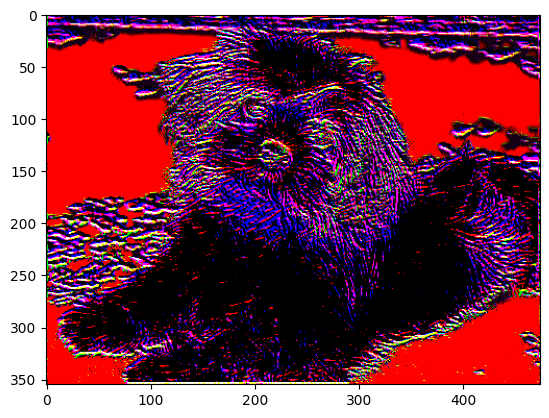

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


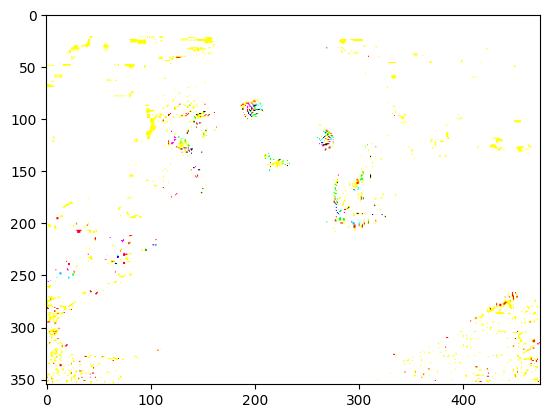

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

class NonResidualConvolutionBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
class ResidualConvolutionBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        input = x # saving input for residual
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = x + input # adding input to output
        x = self.relu(x)
        return x # adding input to output
    

    
non_residual = NonResidualConvolutionBlock()
residual = ResidualConvolutionBlock()

non_residual = non_residual.cuda()
residual = residual.cuda()


img = np.array(Image.open("dog.jpeg"))
img = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().cuda() # just needed for torch
print("performing inference")
out_non_res = non_residual(img)
out_res = residual(img)

print("done")

out_non_res = out_non_res.permute(0,2,3,1).cpu().detach().numpy()[0,...]
out_res = out_res.permute(0,2,3,1).cpu().detach().numpy()[0]

print("plotting out")
plt.imshow(out_non_res)
plt.show()

plt.imshow(out_res)
plt.show()


The residual block can provide stability in very deep neural network, which allowed the creation of the resnet 50, 101, 152.
In resnet you have multiple of these blocks connected together in series like so:

In [2]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1 conv
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 conv
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        #! residual connection
        out += identity
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        # block 1 for input
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # bottleneck blocks
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # classifier
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
resnet = ResNet50()
resnet = resnet.cuda()

img = np.array(Image.open("dog.jpeg"))
img = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().cuda() # just needed for torch
print("performing inference")
out = resnet(img)
n_layers = 0
new_state_dict = resnet.state_dict()

for name, param in new_state_dict.items():
    
    n_layers += 1
    
print("Network has {} layers".format(n_layers))
print(resnet.children())
print(out.shape)


performing inference
Network has 320 layers
<generator object Module.children at 0x7f5201a065e0>
torch.Size([1, 1000])




## DenseNet
DenseNet improved upon the idea of the residual block by introducing the idea of dense blocks. In dense blocks the output of each layer is concatenated with the output of all the previous layers. This way the network can learn from all the previous layers. 

## Inception
The inception net improves uppon all the previous ideas by trying to incorporate all the previously mentioned features plus providing both global and local feature extraction.


(355, 474, 12)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(168270, 3)


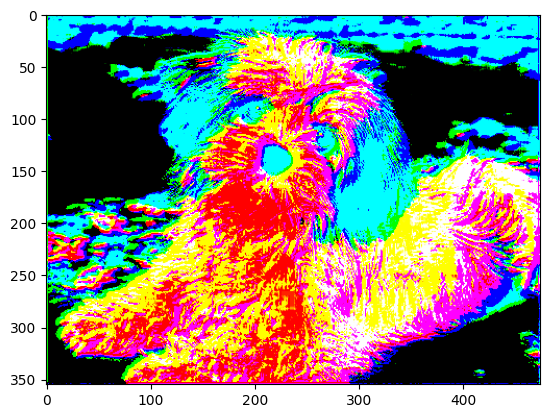

In [3]:
from sklearn.decomposition import PCA
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 5, padding=2)
        self.conv4 = nn.Conv2d(in_channels, out_channels, 1)
        self.pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        # pixel level extraction
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        
        #local feature extraction
        x2 = self.conv2(x)
        x2 = self.relu(x2)
        
        #large feature extraction
        x3 = self.conv3(x)
        x3 = self.relu(x3)
        
        #global feature extraction
        x4 = self.conv4(x)
        x4 = self.relu(x4)
        x4 = self.pool(x4)
        
        x = torch.cat([x1,x2,x3,x4], dim=1)
        return x
    
inception = InceptionBlock(3, 3)
inception = inception.cuda()

img = np.array(Image.open("dog.jpeg"))
img = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().cuda() # just needed for torch

out = inception(img)
out = out.permute(0,2,3,1).cpu().detach().numpy()[0,...]
print(out.shape)
out = np.reshape(out,(-1,12))
out = PCA(n_components=3).fit_transform(out)
print(out.shape)
out = out.reshape(355,474,3)

plt.imshow(out)
plt.show()


# Decoders
So the networks above are much more capable than just deciding whether we are looking at a dog or a cat. These networks are capable of extracting parts of the image, learn its features to extract the image into a feature vector, or latent representation. From the latent we can perform an upsampling to do segmentation or densely connect it to do classification. In this section we going to talk about the different upsampling techniques and how they work.

## FCN
Was the first decoder design that was entirely relying on convolution. 
It is very basic, entirely relying on an up sampling layer.
![FCN 32](Illustration-of-different-FCN-architectures-a-Illustration-of-FCN-32-architecture-b.gif "FCN 32")
## U-Net
the big advancement in decoders, using staged up sampling to decode the image data, with convolution in between providing much more accurate decoding.
![U-Net](unet.jpeg "U-Net") 

### Upsampling
The original design uses a basic upsampling which just resizes the image to twice as big, however more modern approaches also uses `Conv2DTranspose` which is a convolutional layer that performs an upsampling. This is a much more accurate way of sampling the image (as long as the sampler is trained well).

In [4]:
from torch.nn import Conv2d, ConvTranspose2d
from torchvision.models import vgg16

class UnetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = Conv2d(512, 256, 3, padding=1)
        self.upsampler1 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv2 = Conv2d(256, 128, 3, padding=1)
        self.upsampler2 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv3 = Conv2d(128, 64, 3, padding=1)
        self.upsampler3 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv4 = Conv2d(64, 32, 3, padding=1)
        self.upsampler4 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv5 = Conv2d(32, 16, 3, padding=1)
        self.upsampler5 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.classifier = Conv2d(16, 3, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsampler1(x)
        x = self.conv2(x)
        x = self.upsampler2(x)
        x = self.conv3(x)
        x = self.upsampler3(x)
        x = self.conv4(x)
        x = self.upsampler4(x)
        x = self.conv5(x)
        x = self.upsampler5(x)
        x = self.classifier(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = vgg16(pretrained=True).features  # Use only the features
        self.decoder = UnetDecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
autoencoder = AutoEncoder()

autoencoder = autoencoder.cuda()








/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

dataset = datasets.CIFAR10(root="./data",
                           train=True,
                           download=True,
                           transform=ToTensor()
                           )

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=0
                                           )

def train_model(model,epochs = 10, optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001),criterion = nn.MSELoss()):
    
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch+1))
        prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for data in prog_bar:
            img,label = data[1]
            
            img = img.cuda()
            optimizer.zero_grad()
            out = model(img)
    
            loss = criterion(out, img)
            loss.backward()
            optimizer.step()
            
            prog_bar.set_description("Loss: {:.4f}".format(loss.item()))
    return model

autoencoder = train_model(autoencoder, epochs=10)


Files already downloaded and verified
Epoch: 1


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/196 [00:00<?, ?it/s]

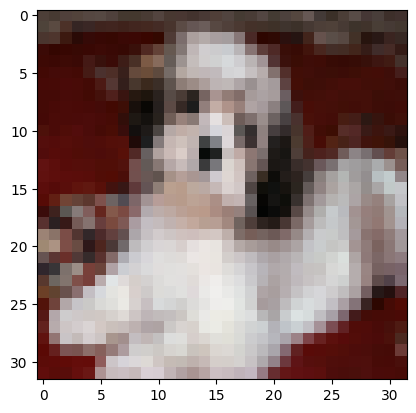

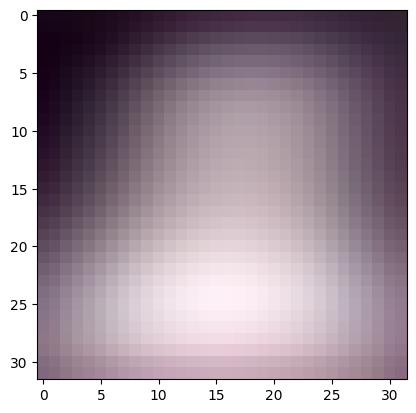

In [6]:

img = np.array(Image.open("dog.jpeg").resize((32,32)))
plt.imshow(img)
plt.show()

img = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().cuda() # just needed for torch
out = autoencoder(img)
out = out.permute(0,2,3,1).cpu().detach().numpy()[0,...]
# normalize out
out = (out - np.min(out)) / (np.max(out) - np.min(out))

plt.imshow(out)
plt.show()



## SegNet

Segnet introduced the pooling indices which is a similar idea to the previously looked at residuals however it usually spans across the network. The idea is that the pooling indices are used to upsample the image. This way the network can learn to upsample the image. This is a very important idea that is used in most networks today.
As it was proven before however that the model relies usually a lot on these indices hence their bias has to be tuned down.

### Max pooling indices

Epoch: 1


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/196 [00:00<?, ?it/s]

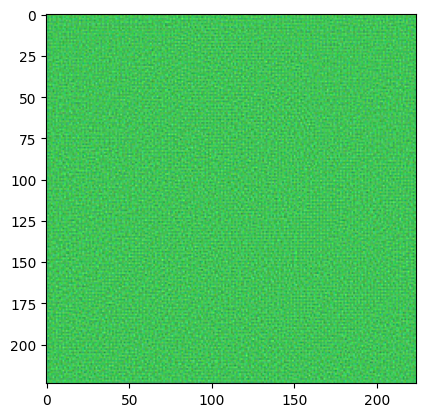

In [9]:
from torchvision import transforms
class NetworkWithPoolingIndices(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)

        # Decoder
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.conv6 = nn.Conv2d(256, 128, 3, padding=1)  # Note the change here
        self.unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, 3, padding=1)  # And here
        self.unpool3 = nn.MaxUnpool2d(2, stride=2)
        self.conv8 = nn.Conv2d(64, 32, 3, padding=1)   # And here
        self.unpool4 = nn.MaxUnpool2d(2, stride=2)
        self.conv10 = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        # Encoding
        x = self.conv1(x)
        x, indices1 = self.pool1(x)
        x = self.conv2(x)
        x, indices2 = self.pool2(x)
        x = self.conv3(x)
        x, indices3 = self.pool3(x)
        x = self.conv4(x)
        x, indices4 = self.pool4(x)
        x = self.conv5(x)

        # Decoding
        x = self.unpool1(x, indices4)
        x = self.conv6(x)
        x = self.unpool2(x, indices3)
        x = self.conv7(x)
        x = self.unpool3(x, indices2)
        x = self.conv8(x)
        x = self.unpool4(x, indices1)
        x = self.conv10(x)

        return x

# Instantiate the model and move it to CUDA if available
pooling_network = NetworkWithPoolingIndices()
pooling_network = pooling_network.cuda() if torch.cuda.is_available() else pooling_network

# Define the train_model function or ensure its correct implementation
pooling_network = train_model(pooling_network, epochs=10)

# Load and preprocess the image
img = Image.open("dog.jpeg")
# Resize, convert to tensor, normalize, etc. as required by your model
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust as needed
    transforms.ToTensor(),
    # Add any other transformations like normalization
])
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.cuda() if torch.cuda.is_available() else img  # Move to CUDA if available

# Run the model
out = pooling_network(img)

# Postprocess and visualize the output
out = out.permute(0, 2, 3, 1).cpu().detach().numpy()[0,...]
out = (out - np.min(out)) / (np.max(out) - np.min(out))  # Normalize
plt.imshow(out)
plt.show()

## PSPNet
Pyramid pooling is a technique that is used to extract features from different scales. The idea is that we use different pooling layers to extract features from different scales. This way the network can learn to extract features from different scales. 
The previously mentioned inception net also uses this idea however it is not as explicit as in PSPNet.

### Pyramid pooling
![Pyramid pooling](Illustration-of-the-pyramid-pooling-Module-Zhao-etal-2017-This-module-is-used-in.png "Pyramid pooling")

In [12]:
import torch.nn.functional as F

class SpatialPyramidPooling(nn.Module):
    def __init__(self, levels):
        super(SpatialPyramidPooling, self).__init__()
        self.levels = levels

    def forward(self, x):
        batch_size, c, h, w = x.size()
        for i, level in enumerate(self.levels):
            level_h, level_w = level
            kernel_h = h // level_h
            kernel_w = w // level_w
            stride_h = h // level_h
            stride_w = w // level_w
            pooling = F.avg_pool2d(x, kernel_size=(kernel_h, kernel_w), stride=(stride_h, stride_w))

            if i == 0:
                spp = pooling.view(batch_size, -1)
            else:
                spp = torch.cat((spp, pooling.view(batch_size, -1)), 1)

        return spp
    
pyramid_module = SpatialPyramidPooling([(1,1), (2,2), (4,4)])

    




## DeepLab
The key idea that deep lab introduced, is that instead of using traditional convolution we use atrous convolution. Atrous convolution is a convolution that has a dilation rate. This way the network can learn to extract features from different scales, without actually ever rescaling the feature map. Such that it provides similar benefits to the original SPPM however reduces the number of parameters in the network.
### Atrous convolution
![Atrous convolution](Atrous-spatial-pyramid-pooling-ASPP-module-which-applies-four-layers-to-the.ppm "Atrous convolution")


In [18]:

class AtrousSpatialPyramidPoolingModule(nn.Module):
    def __init__(self):
        super(AtrousSpatialPyramidPoolingModule, self).__init__()
        # 1x1 conv
        self.conv1 = nn.Conv2d(512, 256, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU(inplace=True)

        # 3x3 conv
        self.conv3_1 = nn.Conv2d(512, 256, kernel_size=3, dilation=6, padding=6, bias=False)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.relu3_1 = nn.ReLU(inplace=True)

        self.conv3_2 = nn.Conv2d(512, 256, kernel_size=3, dilation=12, padding=12, bias=False)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.relu3_2 = nn.ReLU(inplace=True)

        self.conv3_3 = nn.Conv2d(512, 256, kernel_size=3, dilation=18, padding=18, bias=False)
        self.bn3_3 = nn.BatchNorm2d(256)
        self.relu3_3 = nn.ReLU(inplace=True)

        self.conv3_4 = nn.Conv2d(512, 256, kernel_size=3, dilation=24, padding=24, bias=False)
        self.bn3_4 = nn.BatchNorm2d(256)
        self.relu3_4 = nn.ReLU(inplace=True)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_last = nn.Conv2d(512, 256, kernel_size=1, bias=False)
        self.bn_last = nn.BatchNorm2d(256)
        self.relu_last = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # 1x1
        input_size = x.size()
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu1(x1)

        # 3x3 rate=6
        x3_1 = self.conv3_1(x)
        x3_1 = self.bn3_1(x3_1)
        x3_1 = self.relu3_1(x3_1)

        # 3x3 rate=12
        x3_2 = self.conv3_2(x)
        x3_2 = self.bn3_2(x3_2)
        x3_2 = self.relu3_2(x3_2)

        # 3x3 rate=18
        x3_3 = self.conv3_3(x)
        x3_3 = self.bn3_3(x3_3)
        x3_3 = self.relu3_3(x3_3)

        # 3x3 rate=24
        x3_4 = self.conv3_4(x)
        x3_4 = self.bn3_4(x3_4)
        x3_4 = self.relu3_4(x3_4)

        # image pool and upsample
        image_features = self.avg_pool(x)
        image_features = self.conv_last(image_features)
        image_features = self.bn_last(image_features)
        image_features = self.relu_last(image_features)
        image_features = F.interpolate(image_features, size=input_size[2:], mode='bilinear', align_corners=True)

        # concatenate
        x = torch.cat([x1, x3_1, x3_2, x3_3, x3_4, image_features], dim=1)
        x = self.dropout(x)

        return x


    
aspp = AtrousSpatialPyramidPoolingModule()
aspp = aspp.cuda()

img = np.array(Image.open("dog.jpeg").resize((224,224)))
img = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().cuda() # just needed for torch
two_images = torch.cat([img,img], dim=0)

class ModelWithASPPM(nn.Module):
    def __init__(self):
        super(ModelWithASPPM, self).__init__()
        self.features = vgg16(pretrained=True).features
        self.aspp = AtrousSpatialPyramidPoolingModule()
        self.classifier = nn.Conv2d(256 * 6, 3, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = self.classifier(x)
        return x

asppm_model = ModelWithASPPM()

asppm_model = asppm_model.cuda() if torch.cuda.is_available() else asppm_model

asppm_model = train_model(asppm_model, epochs=10)
asppm_model.eval()



out = asppm_model(two_images)


Epoch: 1


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/196 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


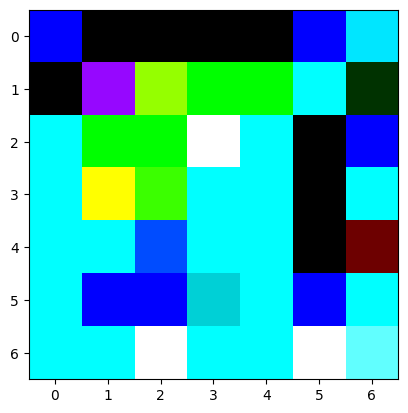

In [19]:
plt.imshow(out[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

As we don't have an actual decoder this is what our network leart during training. However the pyramid pooling module, maybe the first time in convolutional networks, that we can actually see that the network is learning to extract features from different scales.